Class: DSC630 Data Preparation <br>
Name: Eros Perez<br>
Week: 8<br>
Last Update: 1/31/25

### Import Modules

In [222]:
#Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [146]:
#Install pmdarima to select best paramters. We will check 
#ACF/PACF plots to confirm orders

# !pip install pmdarima

### Bring in data and inspect

In [168]:
#Bring in data
df = pd.read_csv('us_retail_sales.csv')

In [131]:
df.head()
df.iloc[0:1,0:13]

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0


### 1) Pivot Data and visualize it

In [170]:
df_melted = df.melt(id_vars=['YEAR'], var_name='Month', value_name='Value')

# # # Convert three-letter month abbreviations to numbers
df_melted['Month'] = pd.to_datetime(df_melted['Month'], format='%b').dt.month

# # # Create a new datetime column
df_melted['Date'] = pd.to_datetime(df_melted[['YEAR', 'Month']].assign(DAY=1))

# # # Drop unnecessary columns and reorder
df_final = df_melted[['Date', 'Value']]

df_final = df_final.sort_values(by="Date").reset_index(drop=True)


In [174]:
#Format DF for Model - Run this code once
df_final['Date'] = pd.to_datetime(df_final['Date'])
df_final.set_index('Date', inplace=True)
df_final = df_final.asfreq('MS')  # Ensure monthly frequency

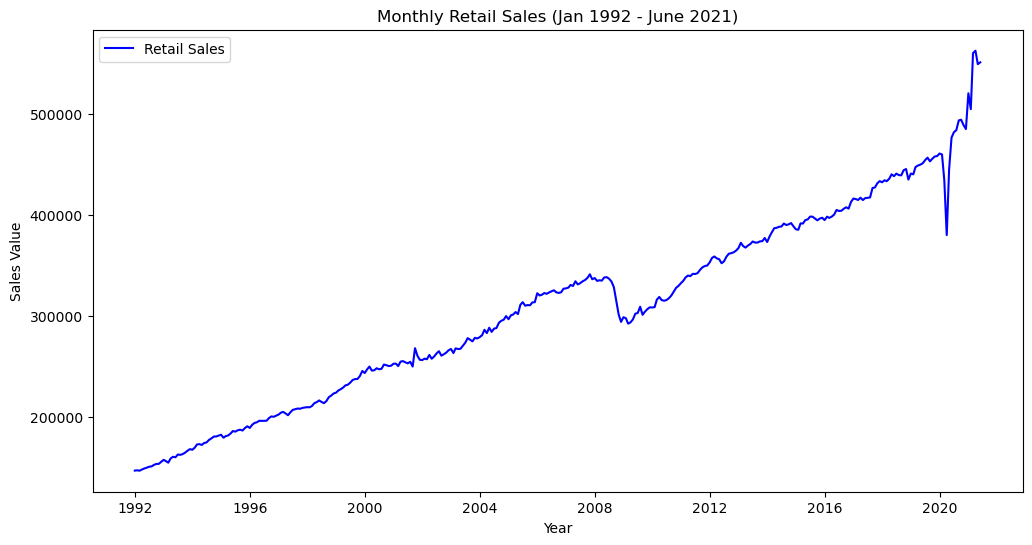

In [184]:
# 1. Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df_final, label="Retail Sales", color='blue')
plt.title("Monthly Retail Sales (Jan 1992 - June 2021)")
plt.xlabel("Year")
plt.ylabel("Sales Value")
plt.legend()
plt.grid(False)
plt.show()

### 2) Split data into training and test set

<Axes: xlabel='Date'>

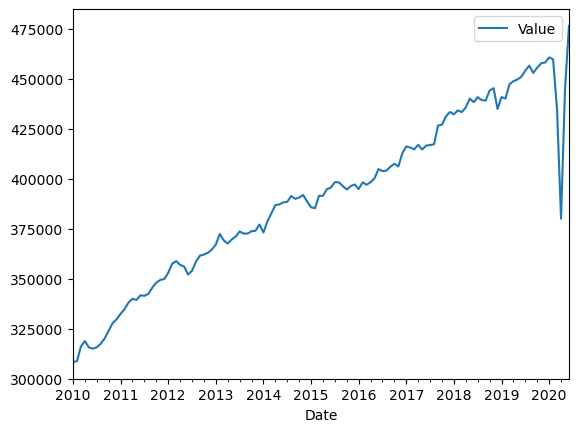

In [280]:
# Step 2: Split into training and test set
train = df_final.loc['2010-01':'2020-06']
test = df_final.loc['2020-07':'2021-06']
train.plot()

In [458]:
# Step 3: Use auto_arima to find best SARIMA parameters, we need to use m=12
auto_model = auto_arima(train, seasonal=True, m=12, d = 1, D=1, trace=True, suppress_warnings=True)
best_order = auto_model.order  # (p,d,q)
best_seasonal_order = auto_model.seasonal_order  # (P,D,Q,s)

#Note: I used this to find the best parameters, however, the outcome was a flat forecast as the data was stationary.
#I then manually adjusted the parameters below to find a model that results in the lowest RMSE

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2399.214, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2402.545, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2402.535, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2400.745, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2407.512, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=2407.372, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2400.683, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2400.676, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2402.794, Time=0.02 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=2400.735, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.930 seconds


### 3) Build predictive model. I used SARIMAX for this model.

In [462]:
sarima_model = SARIMAX(train, 
                       order=(1,2,1),  # Regular ARIMA terms
                       seasonal_order=(1,0,2,12),  # Reduce P to 0
                       enforce_stationarity=True, 
                       enforce_invertibility=False).fit(disp=0)


### 4) Predict monthly retail sales on last year of data

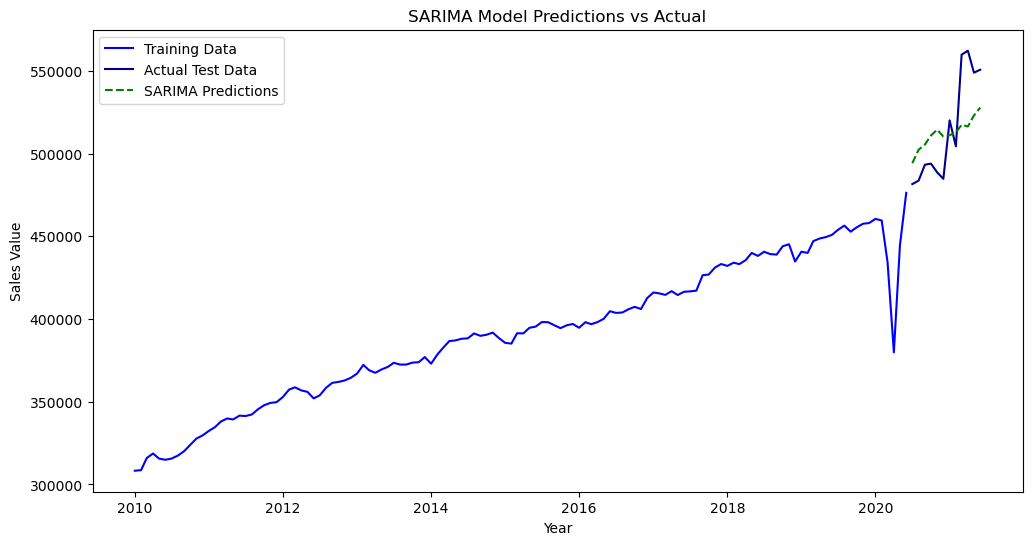

In [480]:

#Now let's forecast on the test set!
forecast = sarima_model.forecast(steps=len(test))

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Training Data", color='blue')
plt.plot(test.index, test, label="Actual Test Data", color='darkblue')
plt.plot(test.index, forecast, label="SARIMA Predictions", color='green', linestyle='dashed')
plt.title("SARIMA Model Predictions vs Actual")
plt.xlabel("Year")
plt.ylabel("Sales Value")
plt.legend()
plt.grid(False)
plt.show()

In [482]:
# Create a DataFrame with actual and forecasted values
df_results = pd.DataFrame({
    'Actual': test.values.flatten(),  
    'Forecast': forecast.values  # Ensure it's the same format as test
}, index=test.index)  # Use the same Date index

# Display the DataFrame
print(df_results)

              Actual       Forecast
Date                               
2020-07-01  481627.0  494255.026041
2020-08-01  483716.0  502415.709902
2020-09-01  493327.0  505500.683685
2020-10-01  493991.0  511025.104750
2020-11-01  488652.0  514544.454345
2020-12-01  484782.0  510352.457800
2021-01-01  520162.0  511161.641304
2021-02-01  504458.0  512883.695177
2021-03-01  559871.0  517486.879338
2021-04-01  562269.0  516450.628013
2021-05-01  548987.0  523157.011033
2021-06-01  550782.0  527892.142427


### Report RMSE of the model predictions on the test set

In [484]:
#Now let's compute RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(round(rmse,0))

25018.0
